In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model

In [2]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
tau_x_1 = False
N = 8
model_type = 'best'
extra_name = ''
if tau_x_1:
    extra_name = '_tau_x_1'
hidden = [200, 200, 50, 50]

## if hidden = [200, 200, 50], uncomment the following 3 lines
# hidden = [200,200,50]
# extra_name = '_no_fourth_layer'
# tau_x_1 = False


#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/trained_models/MultiBody' + str(N) + \
             '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [3]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.quantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#N, use_jet_pt, use_jet_mass are taken from parameters
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr', 'diff_bar','diff_abs_bar', 'diff_dist', 'diff_corr'
# save details whether you want to save it or not
def make_graphs(model_copy, N, use_jet_pt, use_jet_mass, tau_x_1, test_set, part_dataset, zero_bias=False, lrp_type='zero', lrp_param=None,
               graphs=['abs_bar', 'bar', 'dist', 'corr'], figsize=(10, 10), options = '', extra_name=False, save=False):
    options = options if options else 'baseline'
    if extra_name:
        if zero_bias:
            options += '_zero_bias'
        if lrp_type == 'gamma':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'epsilon':
            options += '_LRP-' + lrp_type + '_' + str(lrp_param)
        elif lrp_type == 'zero':
            options += '_LRP-' + lrp_type
        
    classes = []
    if not tau_x_1:
        for i in range(N-1):
            if i != N-2:
                classes.append('tau_'+str(i+1)+'_'+str(0.5))
                classes.append('tau_'+str(i+1)+'_'+str(1))
                classes.append('tau_'+str(i+1)+'_'+str(2))
            else:
                classes.append('tau_'+str(i+1)+'_'+str(1))
                classes.append('tau_'+str(i+1)+'_'+str(2))
        if use_jet_pt:
            classes.append('jet_pt')
        if use_jet_mass:
            classes.append('jet_mass')
    else:
        for i in range(N-1):
            classes.append('tau_'+str(i+1)+'_'+str(1))
        if use_jet_pt:
            classes.append('jet_pt')
        if use_jet_mass:
            classes.append('jet_mass')
    if len(hidden) == 4:
        layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 
                       'dense3', 'relu', 'dropout1', 'dense4', 'relu', 'dropout1', 
                       'dense5', 'softmax']
        L = 14
    else:
        layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 
                       'dense3', 'relu', 'dropout1', 'dense5', 'softmax']
        L = 11
    data,labels = test_set[:]
    full_data = np.concatenate((data,labels),axis=1)
    df_test = pd.DataFrame(full_data, columns=np.append(classes, ['background_prob', 'signal_prob'])).copy()
    if part_dataset == 'sig':
        part_data = df_test.loc[df_test['signal_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
        col=1
    elif part_dataset == 'bkg':
        part_data = df_test.loc[df_test['background_prob'] == 1].drop(columns=['background_prob', 'signal_prob']).to_numpy()
        col=0
    if  'average_feats' in options:
        part_data = df_test.drop(columns=['background_prob', 'signal_prob'])
        part_data = part_data[part_data.columns].mean()*(part_data[part_data.columns] + 1.e-9)/(part_data[part_data.columns] + 1.e-9)
        part_data = part_data.to_numpy()

    A = [torch.from_numpy(part_data).float().cuda()]+[None]*L
    for i in range(L):
        A[i+1] = model_copy._modules[layer_names[i]].forward(A[i])
    def newlayer(layer,g):
        layer = copy.deepcopy(layer)
        with torch.no_grad():
            try: layer.weight = nn.Parameter(g(layer.weight))
            except AttributeError: pass
            if zero_bias:
                try: nn.init.constant_(layer.bias, 0.0)
                except AttributeError: pass
            else:
                try: layer.bias   = nn.Parameter(g(layer.bias))
                except AttributeError: pass
        return layer
    #Combine Dense+Activation functions
    #A[13] uses pre-sigmoid output, A[14] uses sigmoid output. Change the else statement as well
    if len(hidden) == 4:
        B = [A[0], A[3], A[6], A[9], A[12], A[13][:,col][...,None]]
    else:
        B = [A[0], A[3], A[6], A[9], A[10][:,col][...,None]]
    # Backpropagate relevance scores
    if lrp_type == 'zero':
        rho = lambda p: p;                       incr = lambda z: z
    elif lrp_type == 'gamma':
        rho = lambda p: p + lrp_param*p.clamp(min=0); incr = lambda z: z
    elif lrp_type == 'epsilon':
        rho = lambda p: p;                       incr = lambda z: z+lrp_param
        
    R = [None]*(len(B) - 1) + [B[-1]]
    # Iterate over the layers in reverse order
    for l in range(0, len(B)-1)[::-1]:    
        #B[l] = (B[l+1].data).requires_grad_(True)
        B[l] = (B[l].data).requires_grad_(True)
        z = newlayer(model_copy._modules[layer_names[3*l]], rho).forward(B[l]) # setp 1
        if l != len(B) - 2:
            z = model_copy._modules[layer_names[3*l+1]].forward(z)
            z = incr(model_copy._modules[layer_names[3*l+2]].forward(z))
        else:
            z = incr(z[:,col][...,None])
        #Gets rid of zeroes in denominators
        inds_nz = z != 0
        R1_sum = torch.sum(R[l+1].clone())
        R2_sum_nz = torch.sum(R[l+1][inds_nz].clone())
        R[l+1] = R[l+1].clone()*R1_sum/R2_sum_nz
        z = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([1]).cuda(), z)
        R[l + 1] = torch.where(z == torch.FloatTensor([0]).cuda(), torch.FloatTensor([0]).cuda(), R[l+1])

        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = B[l].grad                  # step 3
        R[l] = (B[l]*c).data                                   # step 4
    
    #Plots relevances as normalized
    R[0] = R[0].detach().cpu()
    normal_rel = np.empty_like(R[0])
    #Normalizes relevances for each sample
    normal_rel = (R[0]/np.sum(R[0].detach().numpy(), 1)[:, np.newaxis]).detach().numpy()
    if part_dataset == 'sig': 
        type_set = 'Signal'
    else: 
        type_set = 'Background'
    idx=0
    if 'abs_bar' in graphs:
        print('abs_bar')
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(np.abs(normal_rel_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("Mean |Relevance Score|", fontsize=10)
        if  'average_feats' in options:
            plt.xlabel("|Mean-Behavior Relevance Score|", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        #plt.title("Multi-Body Absolute Value "+type_set+" LRP values")
        idx+=1
        if save:
            #plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_absbar"+options+".png", 
            #            dpi = 150, bbox_inches='tight')
            plt.savefig("figures/LRP_MB8S_{}_{}_absbar.png".format(options, part_dataset),
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'bar' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        abs_relevances = np.nanmean(normal_rel_no_outlier, 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=classes, rels=abs_relevances))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.xlabel("Mean |Relevance Score|", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        #plt.title("Multi-Body "+type_set+" LRP values")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_bar"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'dist' in  graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=figsize)
        shap.summary_plot(normal_rel_no_outlier, sig, feature_names=classes, max_display = 10, plot_type = "dot", show=False)
        #plt.title("Multi-Body "+type_set+" LRP values")
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_dist"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'corr' in graphs:
        normal_rel_no_outlier = removeOutliers(normal_rel)
        plt.figure(idx, figsize=(10,10))
        df_rel_total = pd.DataFrame(normal_rel_no_outlier, columns=classes)
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        #plt.title("Multi-Body "+type_set+" LRP Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/LRP_MB8S_{}_{}_LRPcorr.png".format(options, part_dataset),
                        dpi = 150, bbox_inches='tight')
            #plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_corr"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'feature_corr' in graphs:
        plt.figure(idx, figsize=(10,10))
        df_rel_total = pd.DataFrame(part_data, columns=classes)
        corrmat = df_rel_total.corr()
        sns.heatmap(corrmat, center=0, annot=True, cmap='bwr', fmt='.1f')
        #plt.title("Multi-Body "+type_set+" Feature Correlation Matrix")
        plt.tight_layout()
        idx+=1
        if save:
            #plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_feature_corr"+options+".png", dpi = 150, bbox_inches='tight')
            plt.savefig("figures/LRP_MB8S_{}_{}_featcorr.png".format(options, part_dataset),
                        dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return
    if 'box_whisker' in graphs:
        plt.figure(idx, figsize=figsize)
        df_rel_total = pd.DataFrame(removeOutliers(normal_rel), columns=classes)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(normal_rel, columns=classes)
        df_rel_total = df_rel[sorted_index]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("Multi-Body "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        idx+=1
        if save:
            plt.savefig("figures/"+str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+"/LRP_"+part_dataset+"_box_whisker"+options+".png", dpi = 150, bbox_inches='tight')
        plt.show()
        if idx == len(graphs):
            return 
   
 

abs_bar


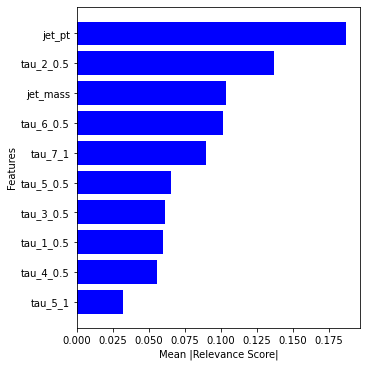

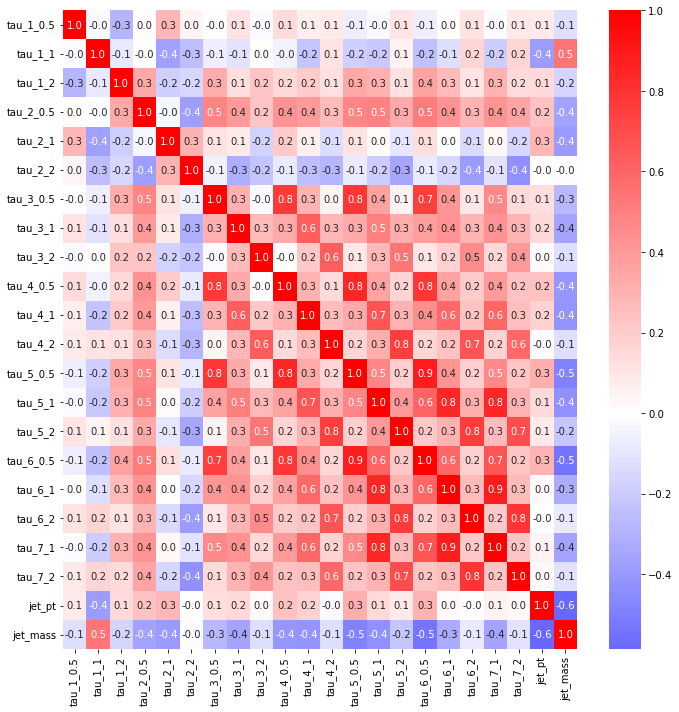

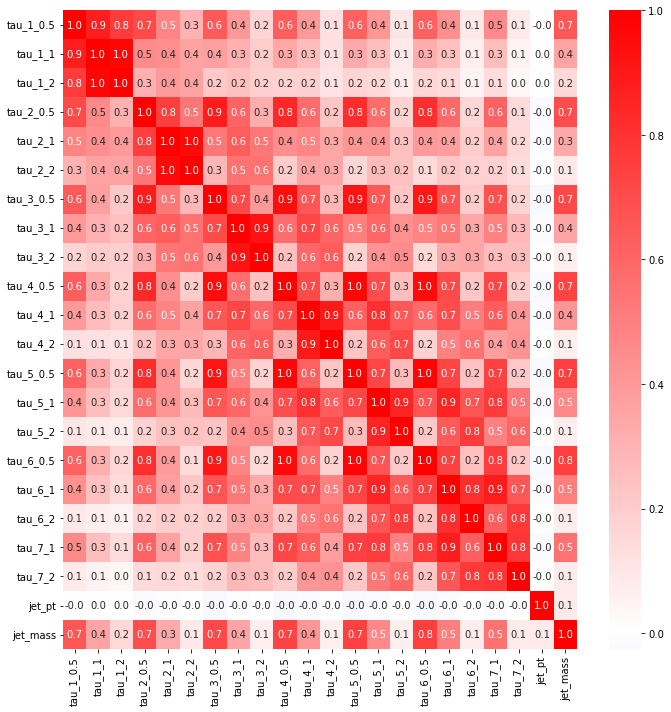

abs_bar


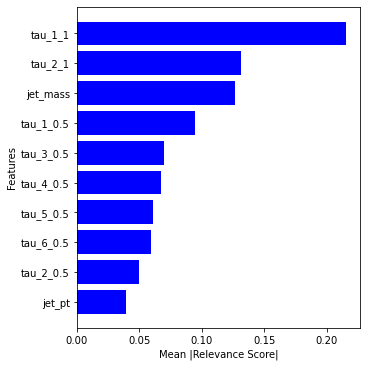

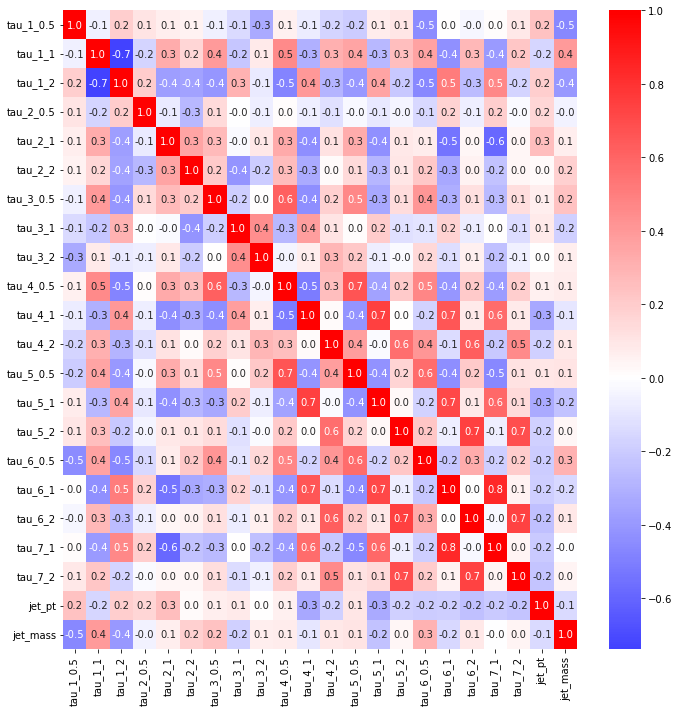

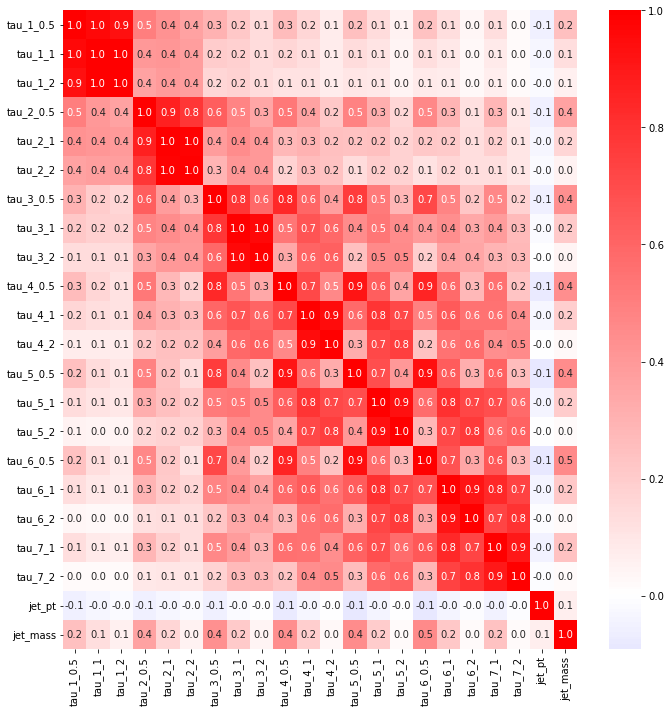

In [4]:
#part_dataset: Choose from 'sig' or 'bkg'
#zero_bias: Choose whether to do zero_bias on LRP
#N, use_jet_pt, use_jet_mass are taken from parameters
#lrp_type: Choose from 'zero', 'epsilon', 'gamma', for LRP-zero, LRP-epsilon, LRP-gamma
#graphs specify which graphs you want in a list. You can only choose from 'abs_bar', 'bar', 'dist', 
# 'corr','box_whisker', 'diff_bar','diff_abs_bar', 'diff_dist', 'diff_corr','diff_box_whisker'
# The ones beggining in diff detail the difference in relevance values of the background/signal output for the part_dataset
# save details whether you want to save it or not
#figsize is the figure size of all plots, options are extra names you can add to end of saved figure 
#when specifying options, suggested to put '_' before the word
#extra_name specifies what LRP type automatically when saving
part_dataset = 'sig'
zero_bias=False
lrp_type='gamma'
lrp_param=4
graphs=['abs_bar', 'feature_corr', 'corr']
figsize=(5,5)
options = ('pt' if use_jet_pt else '') + ('mass' if use_jet_mass else '') + ('_' + extra_name if extra_name else '')
save=False
extra_name=False
for sigtype in ['bkg','sig']:
    total = make_graphs(model_copy=model, N=N, use_jet_pt=use_jet_pt, 
                        use_jet_mass=use_jet_mass, tau_x_1=tau_x_1, 
                        test_set=test_set, part_dataset=sigtype,
                        zero_bias=zero_bias, lrp_type=lrp_type, 
                        lrp_param=lrp_param, graphs=graphs,
                        figsize=figsize, options=options, 
                        extra_name=extra_name, save=save)

abs_bar


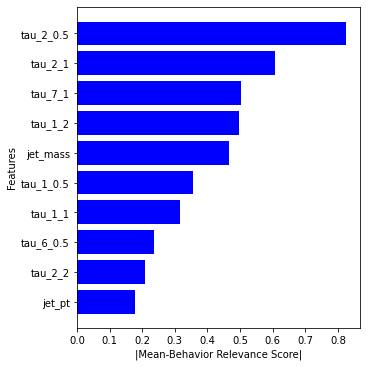

abs_bar


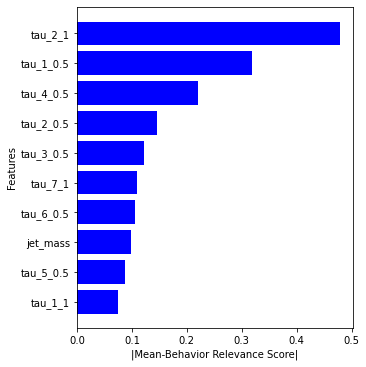

In [5]:
for sigtype in ['bkg','sig']:
    total = make_graphs(model_copy=model, N=N, use_jet_pt=use_jet_pt, 
                        use_jet_mass=use_jet_mass, tau_x_1=tau_x_1, 
                        test_set=test_set, part_dataset=sigtype,
                        zero_bias=zero_bias, lrp_type=lrp_type, 
                        lrp_param=lrp_param, graphs=['abs_bar'],
                        figsize=figsize, options=options + '_average_feats', 
                        extra_name=extra_name, save=save)